**Importação das bibliotecas e leitura do dataset**

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
import warnings

from sklearn.model_selection import (KFold, ParameterGrid,
                                     train_test_split,
                                     GridSearchCV,
                                     ShuffleSplit)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, recall_score,
                             precision_score, f1_score)
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/ML/Projeto Final/

depre = pd.read_csv('Depression Student Dataset.csv')
depre.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ML/Projeto Final


,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,28,2.0,4.0,7-8 hours,Moderate,Yes,9,2,Yes,No
1,Male,28,4.0,5.0,5-6 hours,Healthy,Yes,7,1,Yes,No
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,Yes,10,4,No,Yes
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,Yes,7,2,Yes,No
4,Female,31,1.0,5.0,More than 8 hours,Healthy,Yes,4,2,Yes,No


**Informações das features e verificação de dados faltantes**

In [71]:
depre.info()
print('\nDados Faltantes')
depre.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 502 non-null    object 
 1   Age                                    502 non-null    int64  
 2   Academic Pressure                      502 non-null    float64
 3   Study Satisfaction                     502 non-null    float64
 4   Sleep Duration                         502 non-null    object 
 5   Dietary Habits                         502 non-null    object 
 6   Have you ever had suicidal thoughts ?  502 non-null    object 
 7   Study Hours                            502 non-null    int64  
 8   Financial Stress                       502 non-null    int64  
 9   Family History of Mental Illness       502 non-null    object 
 10  Depression                             502 non-null    object 
dtypes: flo

,0
Gender,0
Age,0
Academic Pressure,0
Study Satisfaction,0
Sleep Duration,0
Dietary Habits,0
Have you ever had suicidal thoughts ?,0
Study Hours,0
Financial Stress,0
Family History of Mental Illness,0


**Divisão das features entre categóricas e numéricas**

In [72]:
numericas = ['Age', 'Academic Pressure', 'Study Satisfaction', 'Study Hours', 'Financial Stress']
categoricas = ['Gender', 'Sleep Duration', 'Dietary Habits',
               'Have you ever had suicidal thoughts ?',
               'Family History of Mental Illness']

**Remoção de dados para imputação posterior**

In [73]:
depre.loc[501, 'Depression'] = np.nan
depre.loc[0, 'Gender'] = np.nan
depre.loc[3, 'Have you ever had suicidal thoughts ?'] = np.nan
depre.loc[4, 'Family History of Mental Illness'] = np.nan
depre.loc[1, 'Sleep Duration'] = np.nan
depre.loc[2, 'Dietary Habits'] = np.nan

depre.head()
print('\nDados Faltantes')
depre.isnull().sum()


Dados Faltantes


,0
Gender,1
Age,0
Academic Pressure,0
Study Satisfaction,0
Sleep Duration,1
Dietary Habits,1
Have you ever had suicidal thoughts ?,1
Study Hours,0
Financial Stress,0
Family History of Mental Illness,1


**Imputação de dados faltantes com moda e mediana**

In [74]:
# Imputação por mediana para colunas numéricas
for col in numericas:
    depre[col].fillna(depre[col].median(), inplace=True)

# Imputação por moda para colunas categóricas
for col in categoricas:
    depre[col].fillna(depre[col].mode()[0], inplace=True)

# Imputação avulsa na classe
depre['Depression'] = depre['Depression'].replace(np.nan, 'No')

print('\nDados Faltantes')
depre.isnull().sum()


Dados Faltantes


,0
Gender,0
Age,0
Academic Pressure,0
Study Satisfaction,0
Sleep Duration,0
Dietary Habits,0
Have you ever had suicidal thoughts ?,0
Study Hours,0
Financial Stress,0
Family History of Mental Illness,0


**Distribuição da classe Depression**

Depression
No     251
Yes    251
Name: count, dtype: int64



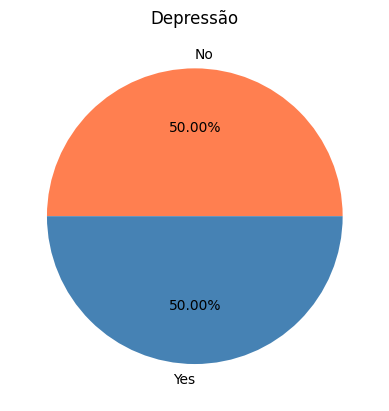

In [75]:
print(depre['Depression'].value_counts())
print()

depre['Depression'].value_counts().plot(kind='pie', autopct='%.2f%%', colors=['coral', 'steelblue'])
plt.title('Depressão')
plt.ylabel('')
plt.savefig('pizza_depression.png')
plt.show()

**EDA Univariada**

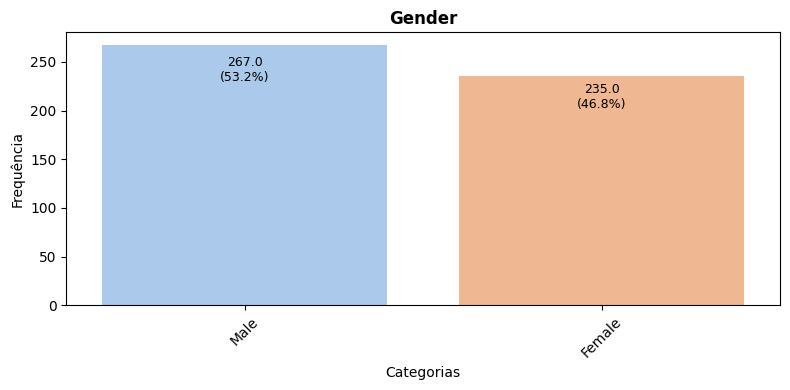

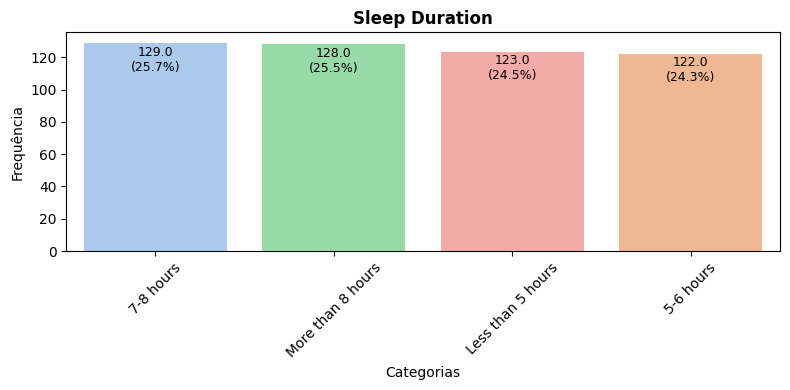

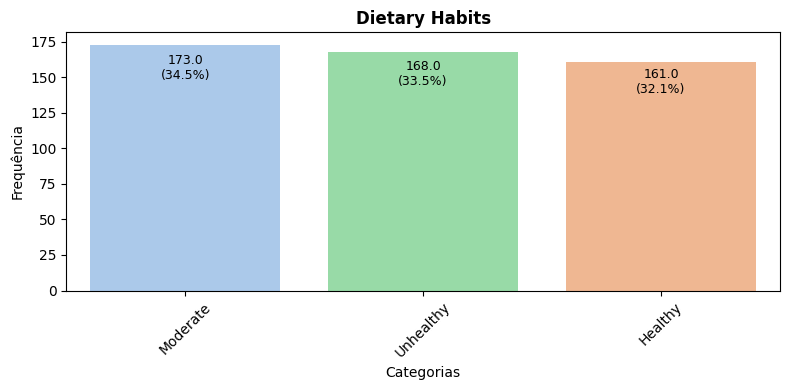

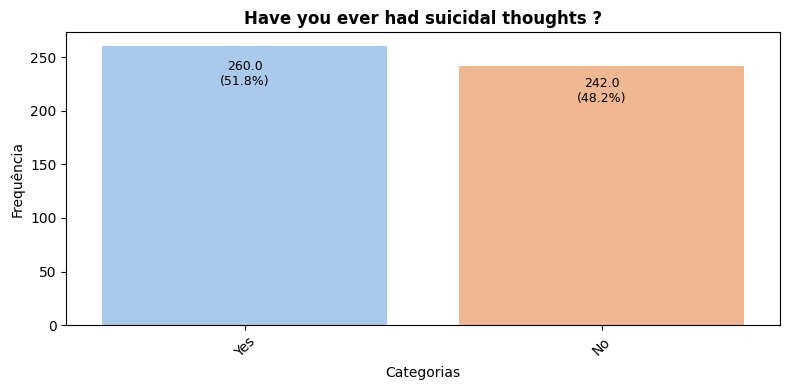

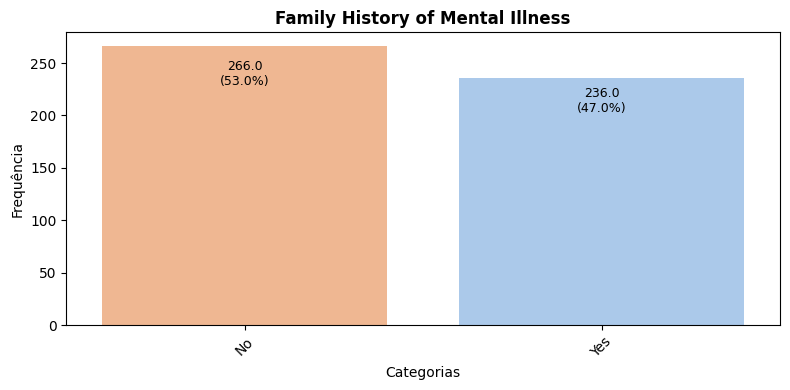

In [76]:
for coluna in categoricas:
    plt.figure(figsize=(8, 4)) # Uma figura para cada gráfico

    ax = sns.countplot(
        x=depre[coluna],
        palette='pastel',  # Paleta suave
        hue=depre[coluna],
        order=depre[coluna].value_counts().index  # Ordena pela frequência
    )

    plt.title(coluna, fontweight='bold')
    plt.xlabel('Categorias')
    plt.ylabel('Frequência')

    # Adiciona porcentagens nas barras
    total = len(depre[coluna])
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width()/2.,       # Posição X do texto
            y=height - (0.15 * height),           # Posição Y do texto
            s=f'{height}\n({height/total:.1%})',
            ha='center',
            va='bottom',
            fontsize=9
        )

    # Ajusta layout
    plt.xticks(rotation=45)  # Rotaciona labels longos
    plt.tight_layout()
    plt.savefig(f'countplot_{coluna}.png')
    plt.show()
    print('\n\n')

In [77]:
depre[numericas].describe()

,Age,Academic Pressure,Study Satisfaction,Study Hours,Financial Stress
count,502.000000,502.000000,502.000000,502.000000,502.000000
mean,26.241036,3.003984,3.075697,6.404382,2.928287
std,4.896501,1.390007,1.373490,3.742434,1.425053
min,18.000000,1.000000,1.000000,0.000000,1.000000
25%,22.000000,2.000000,2.000000,3.000000,2.000000
50%,26.500000,3.000000,3.000000,7.000000,3.000000
75%,30.000000,4.000000,4.000000,10.000000,4.000000
max,34.000000,5.000000,5.000000,12.000000,5.000000


**Pré-Processamento**

In [78]:
# Label encoding
depre['Depression'] = depre['Depression'].replace('No',False)
depre['Depression'] = depre['Depression'].replace('Yes',True)
depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('No',False)
depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('Yes',True)
depre['Family History of Mental Illness'] = depre['Family History of Mental Illness'].replace('No',False)
depre['Family History of Mental Illness'] = depre['Family History of Mental Illness'].replace('Yes',True)

# Convertendo float pra int nas numéricas ordinais
depre['Academic Pressure'] = depre['Academic Pressure'].astype(int)
depre['Study Satisfaction'] = depre['Study Satisfaction'].astype(int)

# One-hot encoding
depre = pd.get_dummies(depre, columns=['Gender', 'Sleep Duration', 'Dietary Habits'])

depre.head()

,Age,Academic Pressure,Study Satisfaction,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression,Gender_Female,Gender_Male,Sleep Duration_5-6 hours,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Unhealthy
0,28,2,4,True,9,2,True,False,False,True,False,True,False,False,False,True,False
1,28,4,5,True,7,1,True,False,False,True,False,True,False,False,True,False,False
2,25,1,3,True,10,4,False,True,False,True,True,False,False,False,False,True,False
3,23,1,4,True,7,2,True,False,False,True,False,False,False,True,False,False,True
4,31,1,5,True,4,2,False,False,True,False,False,False,False,True,True,False,False


In [79]:
X = depre.drop('Depression', axis=1)
y = depre['Depression']

**Histograma**

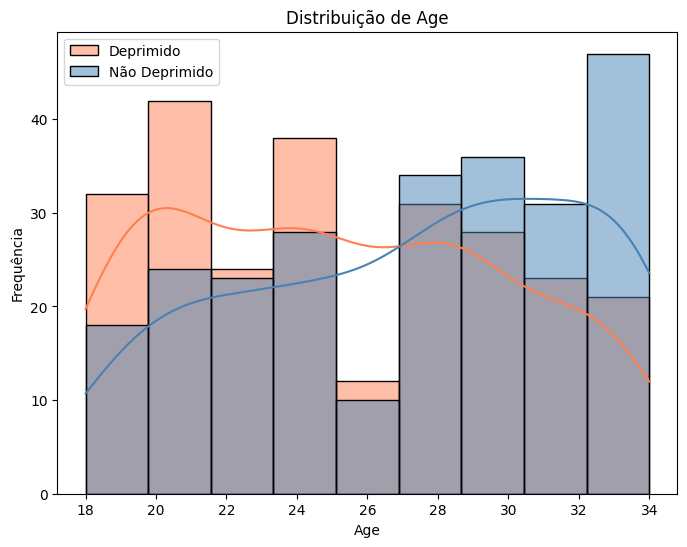

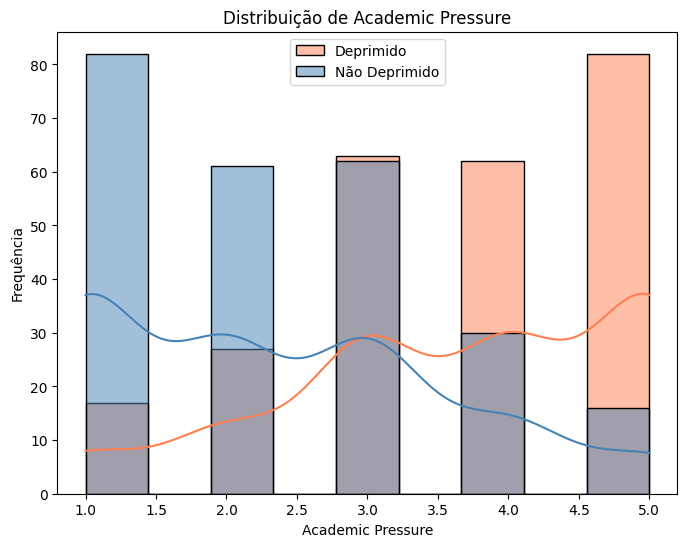

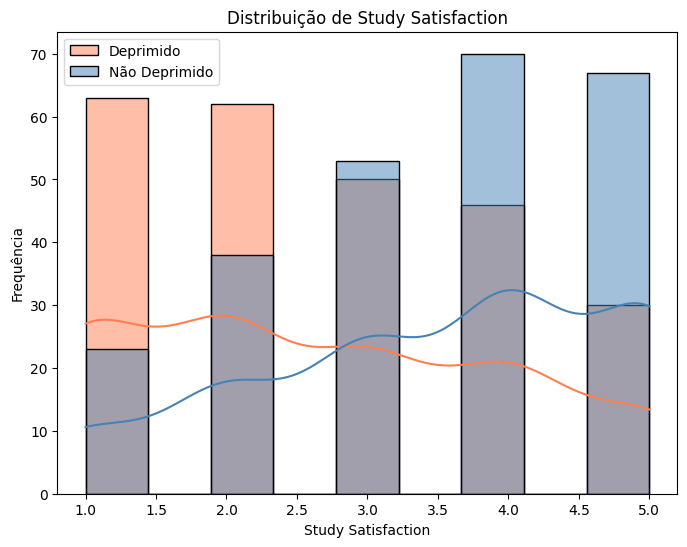

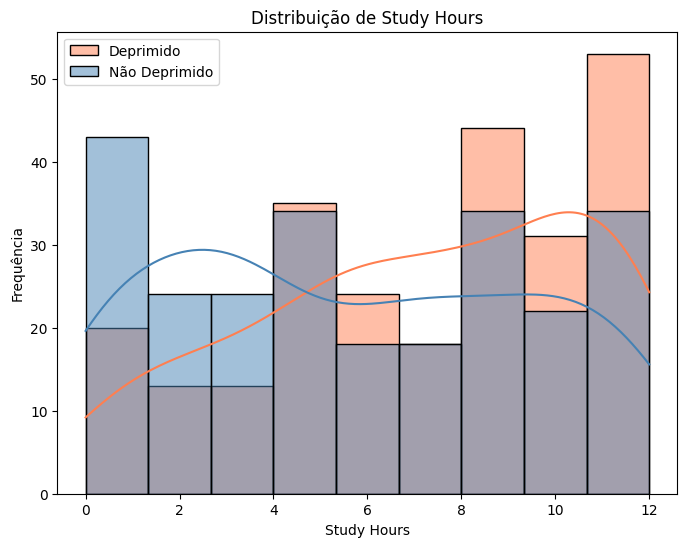

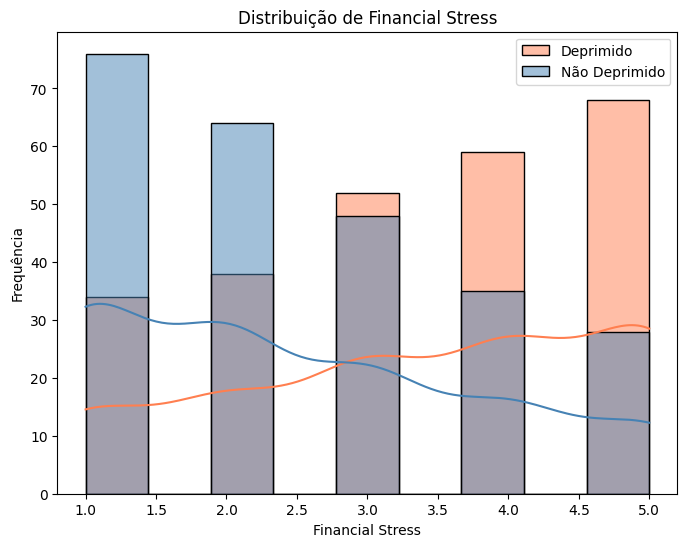

In [80]:
for coluna in numericas:
  plt.figure(figsize=(8, 6))
  sns.histplot(X[y == True][coluna], kde=True, label='Deprimido', color='coral')
  sns.histplot(X[y == False][coluna], kde=True, label='Não Deprimido', color='steelblue')
  plt.xlabel(coluna)
  plt.ylabel('Frequência')
  plt.title(f'Distribuição de {coluna}')
  plt.legend()
  plt.savefig(f'histograma_{coluna}.png')
  plt.show()
  print('\n\n')

**EDA Multivariada**

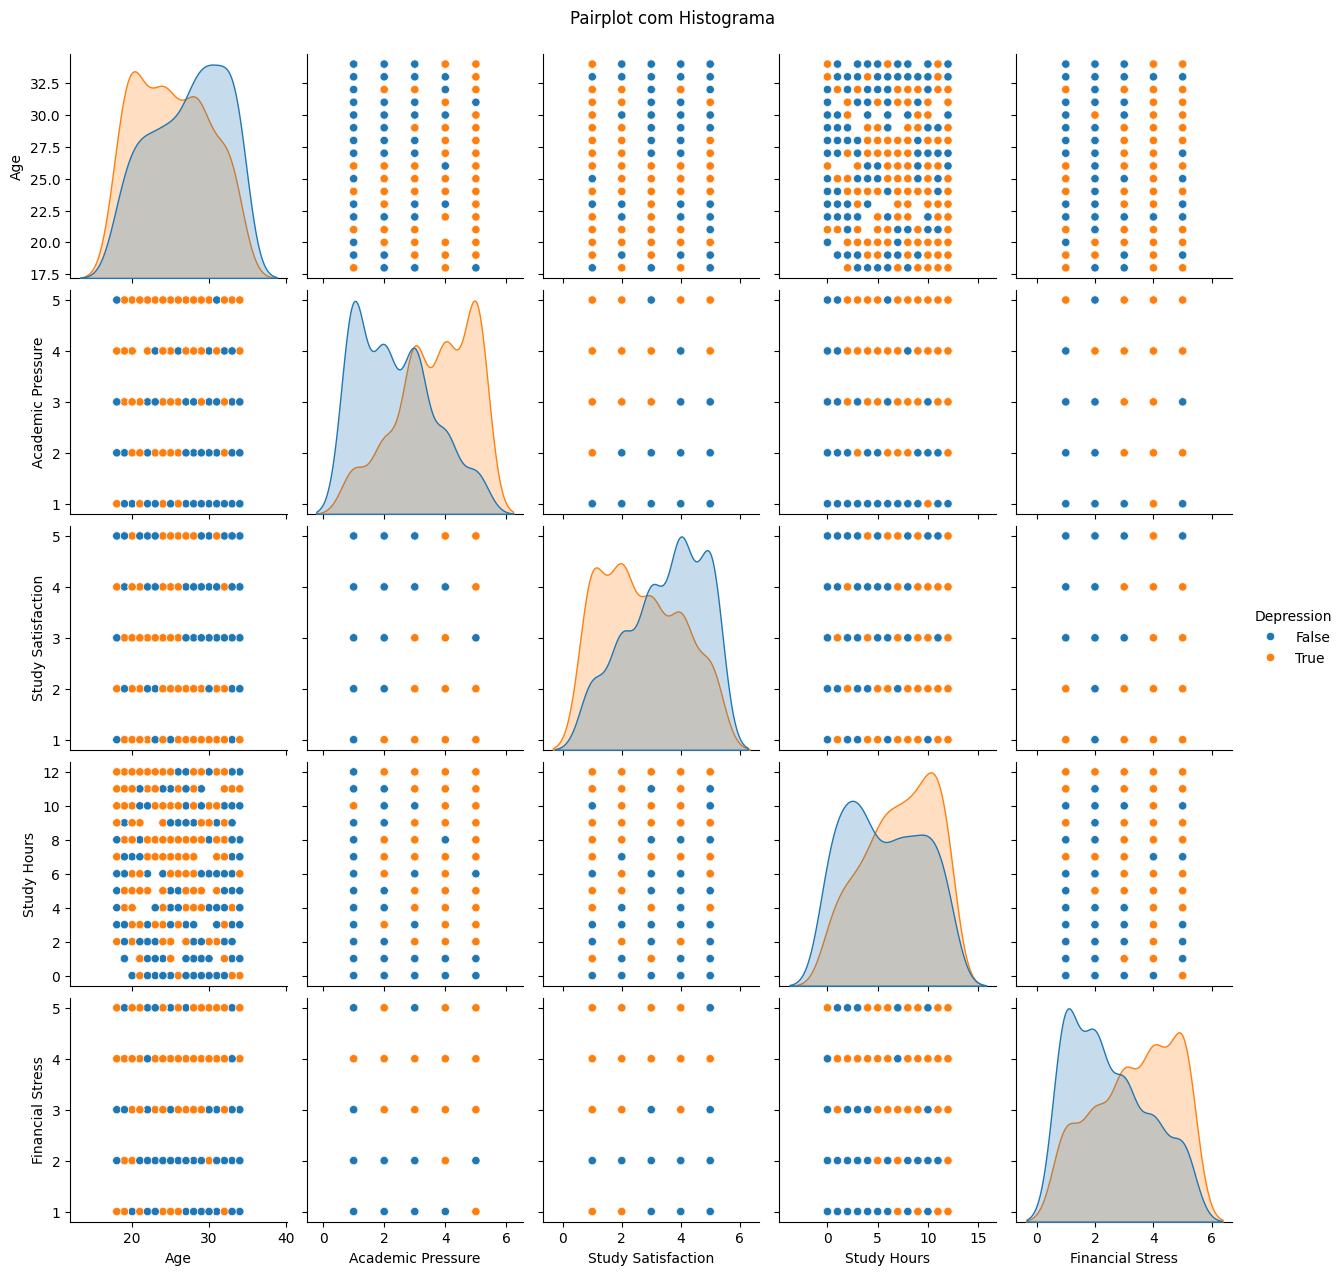

In [81]:
pp_hist = sns.pairplot(
    depre,
    vars=X[numericas],
    hue='Depression',
    diag_kind='kde'
)
plt.suptitle('Pairplot com Histograma', y=1.02)
plt.savefig('pairplot.png', bbox_inches='tight')
plt.show()

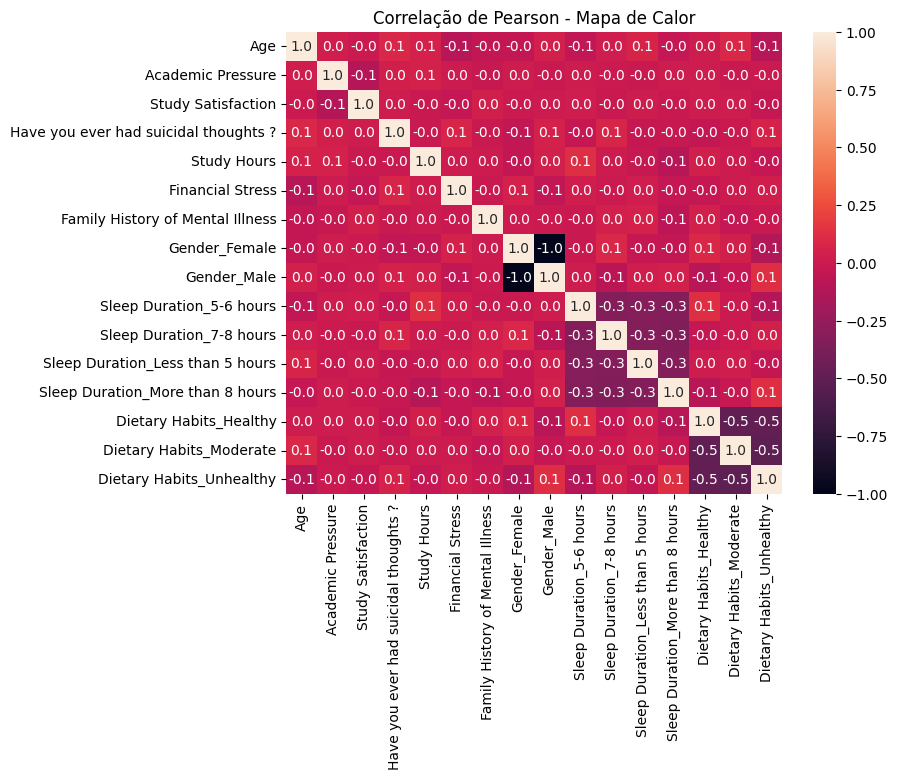

In [82]:
correlacao = X.corr(method='pearson')

plt.figure(figsize=(8, 6))  # Define o tamanho da figura
sns.heatmap(correlacao, annot=True, fmt='.1f')
plt.title('Correlação de Pearson - Mapa de Calor')
plt.savefig('correlação_heatmap.png')
plt.show()


Age - Depression False:
  Q1: 23.00, Q2: 28.00, Q3: 31.00
  Limite Inferior (LI): 11.00
  Limite Superior (LS): 43.00


Age - Depression True:
  Q1: 21.00, Q2: 25.00, Q3: 29.00
  Limite Inferior (LI): 9.00
  Limite Superior (LS): 41.00



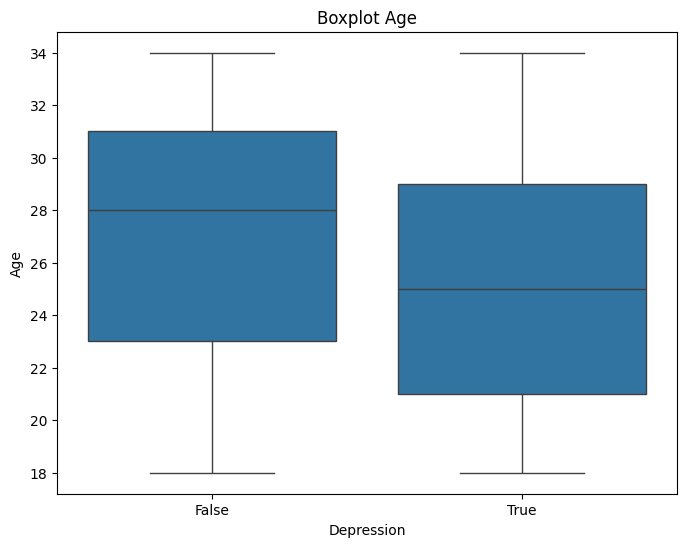


Academic Pressure - Depression False:
  Q1: 1.00, Q2: 2.00, Q3: 3.00
  Limite Inferior (LI): -2.00
  Limite Superior (LS): 6.00


Academic Pressure - Depression True:
  Q1: 3.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): 0.00
  Limite Superior (LS): 8.00



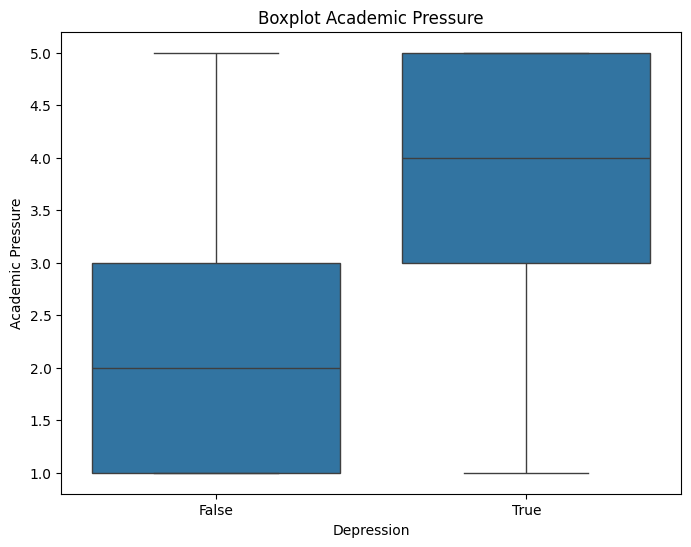


Study Satisfaction - Depression False:
  Q1: 3.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): 0.00
  Limite Superior (LS): 8.00


Study Satisfaction - Depression True:
  Q1: 1.50, Q2: 3.00, Q3: 4.00
  Limite Inferior (LI): -2.25
  Limite Superior (LS): 7.75



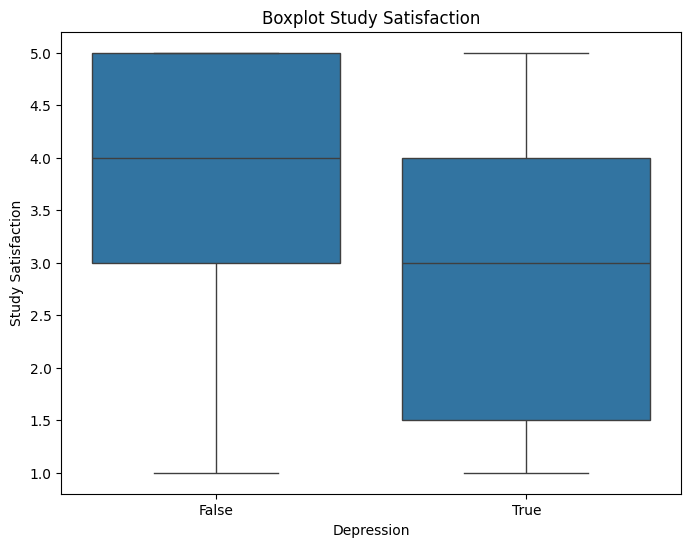


Study Hours - Depression False:
  Q1: 2.00, Q2: 6.00, Q3: 9.00
  Limite Inferior (LI): -8.50
  Limite Superior (LS): 19.50


Study Hours - Depression True:
  Q1: 5.00, Q2: 8.00, Q3: 10.00
  Limite Inferior (LI): -2.50
  Limite Superior (LS): 17.50



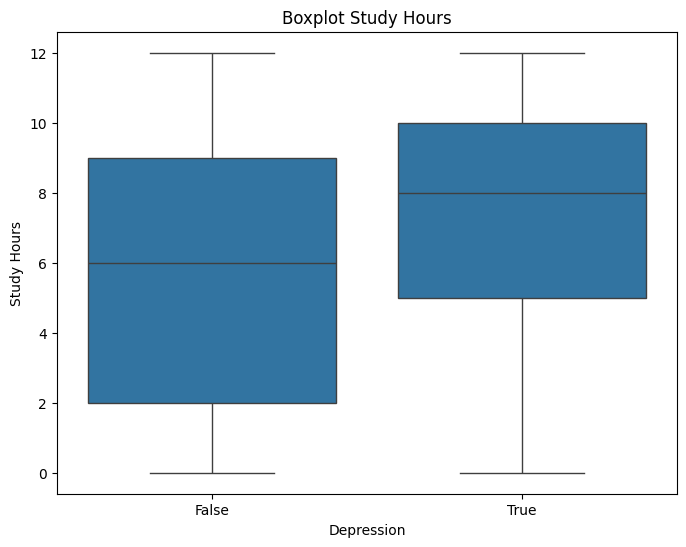


Financial Stress - Depression False:
  Q1: 1.00, Q2: 2.00, Q3: 3.50
  Limite Inferior (LI): -2.75
  Limite Superior (LS): 7.25


Financial Stress - Depression True:
  Q1: 2.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): -2.50
  Limite Superior (LS): 9.50



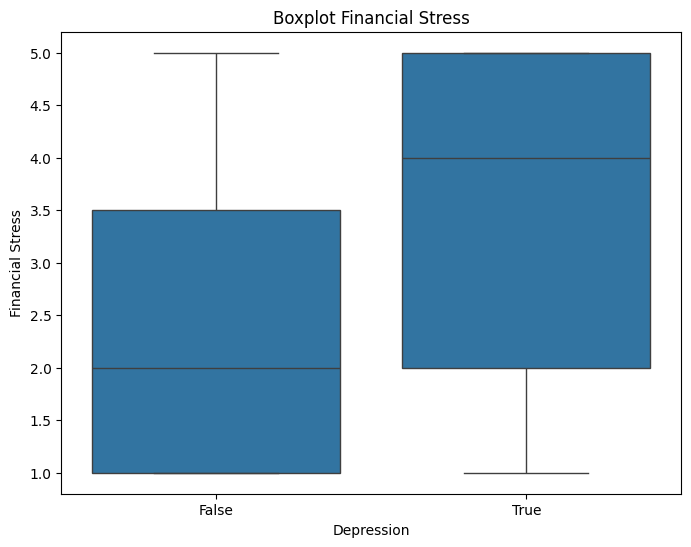

In [83]:
for feature in X[numericas]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=feature, data=X)
    plt.title(f'Boxplot {feature}')

    for class_label in sorted(y.unique()):
        Q1 = X[y == class_label][feature].quantile(0.25)
        Q2 = X[y == class_label][feature].median()
        Q3 = X[y == class_label][feature].quantile(0.75)
        IQR = Q3 - Q1
        LI = Q1 - 1.5 * IQR
        LS = Q3 + 1.5 * IQR

        print(f"\n{feature} - Depression {class_label}:")
        print(f"  Q1: {Q1:.2f}, Q2: {Q2:.2f}, Q3: {Q3:.2f}")
        print(f"  Limite Inferior (LI): {LI:.2f}")
        print(f"  Limite Superior (LS): {LS:.2f}\n")

    plt.savefig(f'boxplot_{feature.replace("/", "_")}.png')
    plt.show()

In [84]:
X = X.values

**Método com ParameterGrid**

In [85]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Hiperparâmetros
parametros_tree = {
    'max_depth': [2, 3, 4, 5, 7, 8, 9, 12],  # Profundidade máxima da árvore
    'criterion': ['gini', 'entropy']                # Critério de divisão
    }
parametros_rf = {
    'n_estimators': [100, 200, 300], # Número de árvores na floresta
    'max_depth': [2, 3, 4, 5, 7, 8, 9, 12],
    'criterion': ['gini', 'entropy']
    }
parametros_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 4, 5, 7, 8, 9, 12],
    'learning_rate': [0.001, 0.01, 0.1],   # Taxa de aprendizado (eta)
    }
parametros_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
    }

tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb = XGBClassifier(random_state=42,
                    objective='binary:logistic',
                    eval_metric='logloss',
                    n_jobs=-1
                    )
svm = SVC(random_state=42)

# Listas para armazenar as métricas
test_scores_tree = []
test_scores_rf = []
test_scores_xgb = []
test_scores_svm = []
best_params_tree = []
best_params_rf = []
best_params_xgb = []
best_params_svm = []

# Lista de modelos com suas configurações
models = [
    {'nome': 'Decision Tree', 'pg': tree, 'parametros': parametros_tree, 'best_params': best_params_tree, 'test_scores': test_scores_tree},
    {'nome': 'Random Forest', 'pg': rf,'parametros': parametros_rf, 'best_params': best_params_rf, 'test_scores': test_scores_rf},
    {'nome': 'XGBoost', 'pg': xgb, 'parametros': parametros_xgb, 'best_params': best_params_xgb, 'test_scores': test_scores_xgb},
    {'nome': 'SVM', 'pg': svm, 'parametros': parametros_svm, 'best_params': best_params_svm, 'test_scores': test_scores_svm}
]

fold = 0

for train_index, test_index in kf.split(X, y):  # Iteração das folds
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Normalização Min-Max
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)  # Ajusta e transforma o treino
    X_test = scaler.transform(X_test)        # Transforma o teste

    X_trainDivided, X_val, y_trainDivided, y_val = train_test_split(X_train, y_train, test_size=0.2)

    # Loop para cada modelo
    for model in models:
        recall_val = []
        param_val = []

        for param in ParameterGrid(model['parametros']):
            temp_model = clone(model['pg'])  # Cria uma cópia "limpa"

            temp_model.set_params(**param)   # Aplica os hiperparâmetros atuais
            temp_model.fit(X_trainDivided, y_trainDivided)  # Treina
            y_pred = temp_model.predict(X_val)
            recall_val.append(recall_score(y_val, y_pred))
            param_val.append(param)

        best_param = param_val[np.argmax(recall_val)]
        model['best_params'].append(best_param)
        best_model = model['pg'].set_params(**best_param)
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        model['test_scores'].append({
            'acuracia': accuracy_score(y_test, y_pred),
            'precisao': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        })

    # Exibição dos resultados
    print("\nFold", fold + 1)
    for model in models:
        scores = model['test_scores'][-1]
        print(f"\n{model['nome']}")
        print(f"  • Acurácia: {scores['acuracia']:.2f}")
        print(f"  • Precisão: {scores['precisao']:.2f}")
        print(f"  • Recall: {scores['recall']:.2f}")
        print(f"  • F1-Score: {scores['f1']:.2f}")
        print("  • Melhores hiperparâmetros")
        print(f"    - {model['best_params'][-1]}")
    print("\n" + "-"*75)
    fold += 1

# Métricas finais com desvio padrão
print("\nMétricas Finais (média e desvio padrão)")
for model in models:
    print(f"\n{model['nome']}")
    print(f"  • Acurácia: {np.mean([s['acuracia'] for s in model['test_scores']]):.2f} ± {np.std([s['acuracia'] for s in model['test_scores']]):.2f}")
    print(f"  • Precisão: {np.mean([s['precisao'] for s in model['test_scores']]):.2f} ± {np.std([s['precisao'] for s in model['test_scores']]):.2f}")
    print(f"  • Recall: {np.mean([s['recall'] for s in model['test_scores']]):.2f} ± {np.std([s['recall'] for s in model['test_scores']]):.2f}")
    print(f"  • F1-Score: {np.mean([s['f1'] for s in model['test_scores']]):.2f} ± {np.std([s['f1'] for s in model['test_scores']]):.2f}\n")


Fold 1

Decision Tree
  • Acurácia: 0.88
  • Precisão: 0.86
  • Recall: 0.93
  • F1-Score: 0.89
  • Melhores hiperparâmetros
    - {'criterion': 'entropy', 'max_depth': 7}

Random Forest
  • Acurácia: 0.94
  • Precisão: 0.90
  • Recall: 1.00
  • F1-Score: 0.95
  • Melhores hiperparâmetros
    - {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}

XGBoost
  • Acurácia: 0.94
  • Precisão: 0.93
  • Recall: 0.96
  • F1-Score: 0.95
  • Melhores hiperparâmetros
    - {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}

SVM
  • Acurácia: 0.94
  • Precisão: 0.93
  • Recall: 0.96
  • F1-Score: 0.95
  • Melhores hiperparâmetros
    - {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

---------------------------------------------------------------------------

Fold 2

Decision Tree
  • Acurácia: 0.84
  • Precisão: 0.80
  • Recall: 0.92
  • F1-Score: 0.86
  • Melhores hiperparâmetros
    - {'criterion': 'entropy', 'max_depth': 2}

Random Forest
  • Acurácia: 0.86
  • Precisão: 0.81

**Método com GridSearchCV**

In [86]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Definição do cross-validation interno (80% treino / 20% teste)
inner_cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Definição dos Grid Searchs
gs_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    parametros_tree,
    cv=inner_cv,
    scoring='recall', # Falsos Negativos como prioridade
    refit=True        # Re-treina o melhor modelo com todos os dados de treino
)
gs_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    parametros_rf,
    cv=inner_cv,
    scoring='recall',
    refit=True,
    n_jobs=-1 # Utiliza todos os núcleos para acelerar o treino
)
gs_xgb = GridSearchCV(
    XGBClassifier(
        objective='binary:logistic',  # Para classificação binária
        eval_metric='logloss',        # Métrica de avaliação interna
        random_state=42,
    ),
    parametros_xgb,
    cv=inner_cv,
    scoring='recall',
    refit=True,
    n_jobs=-1
)
gs_svm = GridSearchCV(
    SVC(),
    parametros_svm,
    cv=inner_cv,
    scoring='recall',
    refit=True
)

# Listas para armazenar as métricas
test_scores_tree = []
test_scores_rf = []
test_scores_xgb = []
test_scores_svm = []
best_params_tree = []
best_params_rf = []
best_params_xgb = []
best_params_svm = []

# Lista de modelos com suas configurações
models = [
    {'nome': 'Árvore de Decisão', 'gs': gs_tree, 'best_params': best_params_tree, 'test_scores': test_scores_tree},
    {'nome': 'Floresta Aleatória', 'gs': gs_rf, 'best_params': best_params_rf, 'test_scores': test_scores_rf},
    {'nome': 'XGBoost', 'gs': gs_xgb, 'best_params': best_params_xgb, 'test_scores': test_scores_xgb},
    {'nome': 'SVM', 'gs': gs_svm, 'best_params': best_params_svm, 'test_scores': test_scores_svm}
]

fold = 0

for train_index, test_index in kf.split(X, y):  # Iteração das folds
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Normalização Min-Max
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)  # Ajusta e transforma o treino
    X_test = scaler.transform(X_test)        # Transforma o teste

    # Loop para cada modelo
    for model in models:
        model['gs'].fit(X_train, y_train)
        best_estimator = model['gs'].best_estimator_  # Por conta do refit
        y_pred = best_estimator.predict(X_test)
        model['best_params'].append(model['gs'].best_params_)
        model['test_scores'].append({
            'acuracia': accuracy_score(y_test, y_pred),
            'precisao': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        })

    # Exibição dos resultados
    print("\nFold", fold + 1)
    for model in models:
        scores = model['test_scores'][-1]
        print(f"\n{model['nome']}")
        print(f"  • Acurácia: {scores['acuracia']:.2f}")
        print(f"  • Precisão: {scores['precisao']:.2f}")
        print(f"  • Recall: {scores['recall']:.2f}")
        print(f"  • F1-Score: {scores['f1']:.2f}")
        print("  • Melhores hiperparâmetros")
        print(f"    - {model['best_params'][-1]}")
    print("\n" + "-"*75)
    fold += 1

# Métricas finais com desvio padrão
print("\nMétricas Finais (média e desvio padrão)")
for model in models:
    print(f"\n{model['nome']}")
    print(f"  • Acurácia: {np.mean([s['acuracia'] for s in model['test_scores']]):.2f} ± {np.std([s['acuracia'] for s in model['test_scores']]):.2f}")
    print(f"  • Precisão: {np.mean([s['precisao'] for s in model['test_scores']]):.2f} ± {np.std([s['precisao'] for s in model['test_scores']]):.2f}")
    print(f"  • Recall: {np.mean([s['recall'] for s in model['test_scores']]):.2f} ± {np.std([s['recall'] for s in model['test_scores']]):.2f}")
    print(f"  • F1-Score: {np.mean([s['f1'] for s in model['test_scores']]):.2f} ± {np.std([s['f1'] for s in model['test_scores']]):.2f}\n")


Fold 1

Árvore de Decisão
  • Acurácia: 0.84
  • Precisão: 0.88
  • Recall: 0.81
  • F1-Score: 0.85
  • Melhores hiperparâmetros
    - {'criterion': 'gini', 'max_depth': 5}

Floresta Aleatória
  • Acurácia: 0.90
  • Precisão: 0.87
  • Recall: 0.96
  • F1-Score: 0.91
  • Melhores hiperparâmetros
    - {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}

XGBoost
  • Acurácia: 0.78
  • Precisão: 0.72
  • Recall: 0.96
  • F1-Score: 0.83
  • Melhores hiperparâmetros
    - {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}

SVM
  • Acurácia: 0.94
  • Precisão: 0.93
  • Recall: 0.96
  • F1-Score: 0.95
  • Melhores hiperparâmetros
    - {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

---------------------------------------------------------------------------

Fold 2

Árvore de Decisão
  • Acurácia: 0.82
  • Precisão: 0.77
  • Recall: 0.92
  • F1-Score: 0.84
  • Melhores hiperparâmetros
    - {'criterion': 'gini', 'max_depth': 2}

Floresta Aleatória
  • Acurácia: 0.88
  • Prec